# Basic Tutorial

Trey V. Wenger (c) July 2024

Here we demonstrate the basic features of a `bayes_spec` model.

In [1]:
# General imports
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

from bayes_spec import BaseModel

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.0.0


## Model Definition

First, we define our model. Here we demonstrate a simple Gaussian line profile model where each "cloud" is expected to produce one Gaussian features. We follow "good" practices by ensuring that the free parameters of the model are normalized so that we are able to efficiently sample the parameter space later. To define a model, we extend the `bayes_spec.BaseModel` class. This class must have two methods: `__init__` and `define`.

In [2]:
from bayes_spec.utils import gaussian

class GaussLine(BaseModel):
    """
    Definition of a Gaussian line profile model.
    """

    def __init__(self, *args, **kwargs):
        """
        Define model parameters, deterministic quantities, posterior
        clustering features, and TeX parameter representations.

        Inputs: see bayes_spec.BaseModel

        Returns: new GaussModel instance
        """
        # Initialize BaseModel
        super().__init__(*args, **kwargs)

        # Define (normalized) cloud free parameter names
        self.cloud_params += [
            "amplitude_norm",
            "fwhm_norm",
            "velocity_norm",
        ]

        # Define deterministic quantities (including un-normalized cloud free parameters)
        self.deterministics += [
            "amplitude",
            "fwhm",
            "velocity",
            "line_area",
        ]

        # Select features used for posterior clustering
        self._cluster_features += [
            "velocity",
            "line_area",
        ]

        # Define TeX representation of each parameter
        self.var_name_map.update(
            {
                "amplitude": r"$T_B$ (K)",
                "fwhm": r"$\Delta V$ (km s$^{-1}$)",
                "velocity": r"$V_{\rm LSR}$ (km s$^{-1}$)",
                "line_area": r"$\int\!T_B\,dV$ (K km s$^{-1}$)",
            }
        )

    def define(self):
        """
        Model definition.

        Inputs: None

        Returns: Nothing
        """
        # add polynomial baseline priors and evaluate the normalized baseline model
        baseline_model_norm = super().add_baseline_priors()

        with self.model:
            # Gaussian amplitude per cloud
            # Half-normal distribution with width = 10 K
            amplitude_norm = pm.HalfNormal(
                "amplitude_norm",
                sigma=1.0,
                dims="cloud",
            )
            amplitude = pm.Deterministic(
                "amplitude", 10.0 * amplitude_norm, dims="cloud"
            )

            # Gaussian FWHM line width per cloud
            # We use a gamma distribution to prevent FWHM -> 0
            # Gamma distribution width mode = 30 km/s
            fwhm_norm = pm.Gamma(
                "fwhm_norm",
                alpha=2.0,
                beta=1.0,
                dims="cloud",
            )
            fwhm = pm.Deterministic("fwhm", 30.0 * fwhm_norm, dims="cloud")

            # Gaussian centroid velocity per cloud
            # Normal distribution with center = 0 km/s and width = 50 km/s
            velocity_norm = pm.Normal(
                "velocity_norm",
                mu=0.0,
                sigma=1.0,
                dims="cloud",
            )
            velocity = pm.Deterministic("velocity", 50.0 * velocity_norm, dims="cloud")

            # Deterministic line area per cloud
            _ = pm.Deterministic(
                "line_area",
                amplitude * fwhm * np.sqrt(np.pi / (4.0 * np.log(2.0))),
                dims="cloud",
            )

            # Evaluate line profile model per cloud, sum over clouds
            # Note that "observation" here is the "name" of our spectrum (see next section)
            predicted_line = gaussian(
                self.data["observation"].spectral[:, None], amplitude, velocity, fwhm
            ).sum(axis=1)

            # Normalize line profile model
            # Again, "observation" here is the "name" of our spectrum
            predicted_line_norm = self.data["observation"].normalize_brightness(
                predicted_line
            )

            # Add normalized baseline model
            # "observation" here is the name of our spectrum, which is also used to index the
            # baseline models.
            predicted = predicted_line_norm + baseline_model_norm["observation"]

            # Evaluate normalized likelihood
            # It is necessary that the likelihood associated with each spectrum is named
            # like "{name}_norm", where "name" is "observation" in this case, and that
            # dims="{name}" as well
            _ = pm.Normal(
                "observation_norm",
                mu=predicted,
                sigma=1.0,
                observed=self.data["observation"].brightness_norm,
                dims="observation",
            )

## Data Format

We wish to generate some synthetic data from our model, which requires us to take a brief aside to introduce the `bayes_spec` data format. We use the `SpecData` class to pass data into `bayes_spec`.

In [3]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = np.random.randn(len(velocity_axis)) # K

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Now that we have a model definition and a dummy data format, we can generate simulated observations by drawing samples from the parameter prior distributions.

Sampling: [amplitude_norm, fwhm_norm, observation_baseline_norm, observation_norm, velocity_norm]


Text(0, 0.5, 'Brightness Temperature (K)')

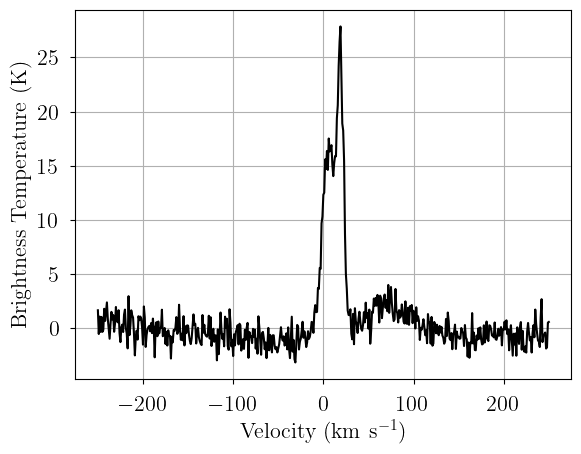

In [4]:
# Initialize and define the model
model = GaussLine(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.define()

# Draw one posterior predictive sample
simulated = model.prior_predictive_check(
    samples=1,
)
sim_brightness = simulated.prior_predictive["observation"].sel(chain=0, draw=0)

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`).

In [6]:
model = GaussLine(data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.define()

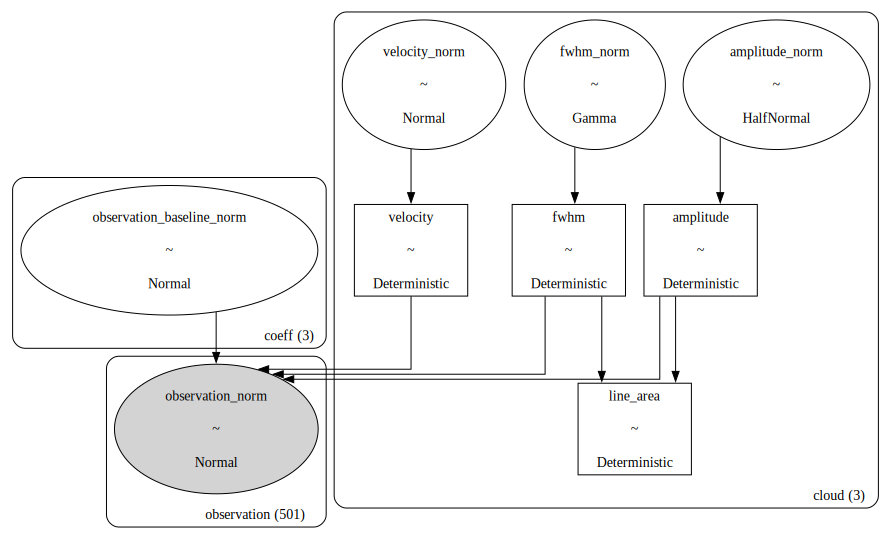

In [7]:
# Plot model graph
model.plot_graph(f"{figdir}/model.gv", "svg")
SVG(f"{figdir}/model.gv.{ext}")

In [8]:
# model string representation
print(model.model.str_repr())

observation_baseline_norm ~ Normal(0, 1)
           amplitude_norm ~ HalfNormal(0, 1)
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
                amplitude ~ Deterministic(f(amplitude_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
                line_area ~ Deterministic(f(fwhm_norm, amplitude_norm))
         observation_norm ~ Normal(f(observation_baseline_norm, amplitude_norm, fwhm_norm, velocity_norm), 1)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [amplitude_norm, fwhm_norm, observation_baseline_norm, observation_norm, velocity_norm]


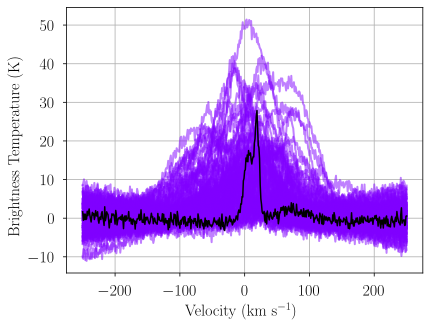

In [9]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive.{ext}",
)
SVG(f"{figdir}/prior_predictive.{ext}")

We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has attributes `cloud_params` for cloud free parameters, `deterministics` for deterministic quantities, `baseline_params` for the free polynomial baseline parameters, and `hyper_params` for the hyperparameters. Here we show the pair plot for the deterministic quantities derived from our prior distributions.

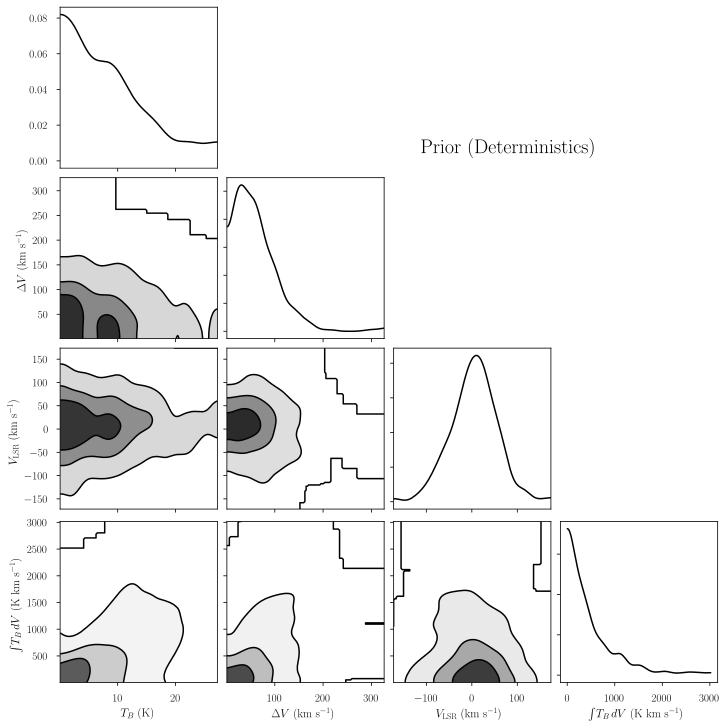

In [10]:
from bayes_spec.plots import plot_pair

plot_pair(
    prior.prior, # samples
    model.deterministics, # var_names to plot
    "Prior (Deterministics)", # plot label
    f"{figdir}/pair_prior_determ.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_prior_determ.{ext}")

## Variational Inference

We can approximate the posterior distribution using variational inference (VI). We will run a maximum of `n` iterations, but stop early if it appears that VI has converged on a solution. If you get a `NaN` error, try increasing `learning_rate` and `abs_tolerance`.

In [11]:
model.fit(
    n = 500_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.01, # VI absolute convergence threshold
    learning_rate = 1e-3, # VI learning rate
)

Output()

Convergence achieved at 34000
Interrupted at 33,999 [6%]: Average Loss = 2,698


In [12]:
# posterior samples stored in model.trace.posterior
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                   20.997  0.561   19.956   22.052      0.017   
amplitude[1]                    8.615  0.309    8.080    9.191      0.010   
amplitude[2]                    9.484  0.334    8.833   10.074      0.011   
amplitude_norm[0]               2.100  0.056    1.996    2.205      0.002   
amplitude_norm[1]               0.862  0.031    0.808    0.919      0.001   
amplitude_norm[2]               0.948  0.033    0.883    1.007      0.001   
fwhm[0]                         7.915  0.227    7.510    8.374      0.007   
fwhm[1]                        19.739  0.752   18.316   21.080      0.023   
fwhm[2]                        14.239  0.588   13.161   15.315      0.019   
fwhm_norm[0]                    0.264  0.008    0.250    0.279      0.000   
fwhm_norm[1]                    0.658  0.025    0.611    0.703      0.001   
fwhm_norm[2]                    0.475  0.020    0.439    0.510      0.001   
line_area[0]                  176.897  6.998  164.698  190.343      0.224   
line_area[1]                  181.019  9.520  163.785  198.156      0.298   
line_area[2]                  143.755  7.845  129.699  159.287      0.245   
observation_baseline_norm[0]   -0.152  0.050   -0.241   -0.054      0.002   
observation_baseline_norm[1]   -0.036  0.050   -0.133    0.055      0.002   
observation_baseline_norm[2]   -0.041  0.036   -0.115    0.023      0.001   
velocity[0]                    19.103  0.133   18.845   19.354      0.005   
velocity[1]                     9.838  0.461    8.980   10.721      0.014   
velocity[2]                     4.412  0.370    3.671    5.047      0.012   
velocity_norm[0]                0.382  0.003    0.377    0.387      0.000   
velocity_norm[1]                0.197  0.009    0.180    0.214      0.000   
velocity_norm[2]                0.088  0.007    0.073    0.101      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.012    1054.0     813.0    NaN  
amplitude[1]                    0.007    1000.0     916.0    NaN  
amplitude[2]                    0.007    1018.0     867.0    NaN  
amplitude_norm[0]               0.001    1054.0     813.0    NaN  
amplitude_norm[1]               0.001    1000.0     916.0    NaN  
amplitude_norm[2]               0.001    1018.0     867.0    NaN  
fwhm[0]                         0.005     914.0     944.0    NaN  
fwhm[1]                         0.016    1056.0     886.0    NaN  
fwhm[2]                         0.013     963.0     944.0    NaN  
fwhm_norm[0]                    0.000     914.0     944.0    NaN  
fwhm_norm[1]                    0.001    1056.0     886.0    NaN  
fwhm_norm[2]                    0.000     963.0     944.0    NaN  
line_area[0]                    0.158     938.0     944.0    NaN  
line_area[1]                    0.211    1024.0     956.0    NaN  
line_area[2]                    0.174    1024.0     903.0    NaN  
observation_baseline_norm[0]    0.001     790.0     851.0    NaN  
observation_baseline_norm[1]    0.001     850.0     882.0    NaN  
observation_baseline_norm[2]    0.001    1185.0    1016.0    NaN  
velocity[0]                     0.003     844.0     905.0    NaN  
velocity[1]                     0.010    1038.0    1016.0    NaN  
velocity[2]                     0.009     946.0     913.0    NaN  
velocity_norm[0]                0.000     844.0     905.0    NaN  
velocity_norm[1]                0.000    1038.0    1016.0    NaN  
velocity_norm[2]                0.000     946.0     913.0    NaN

It's good practice to verify the integrity of your solution! Here we generate posterior predictive checks -- realizations of the model drawn with parameters drawn from the posterior distribution. Each line is one posterior sample.

Sampling: [observation_norm]


Output()

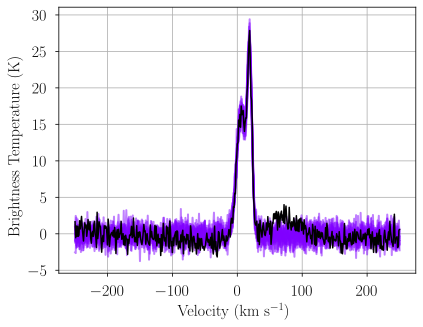

In [13]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_vi.{ext}"
)
SVG(f"{figdir}/posterior_predictive_vi.{ext}")

Notice how VI failed to capture the third Gaussian component.

## MCMC

VI is fast, but it's not particularly accurate, and there is no way to diagnose "convergence". Instead, we sample the posterior distribution using MCMC. Here we initialize the No U-Turn Sampler (NUTS) using VI. We can customize the VI initialization as well as the NUTS parameters. If there are many divergences, or if the resulting effective sample sizes are small and `r_hat` is large, try increasing the number of tuning samples, draws, and/or chains. Increasing `target_accept` to `0.9` or `0.95` can help if there are many divergences. Use as many chains as possible.

In [14]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.01, "learning_rate": 1e-3}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 34000
Interrupted at 33,999 [6%]: Average Loss = 2,698
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, amplitude_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


If a chain does not converge, an error is printed and that chain is dropped from all subsequent analyses. In the remaining chains, there may be some divergences. The number of divergences should be much less than the number of posterior samples.

In general, there could be a labeling degeneracy, or multiple unique solutions. Here we "solve" for those effects using a Gaussian Mixture Model (GMM). The parameter `p_threshold` defines the probability threshold for "unique" GMM solutions.

In [15]:
model.solve(p_threshold=0.9)

GMM converged to unique solution
Chain label order mismatch in solution 0
Chain 0 order: [2 1 0]
Chain 1 order: [1 0 2]
Chain 2 order: [2 0 1]
Chain 3 order: [2 1 0]
Adopting (first) most common order: [2 1 0]


In [16]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                   22.403   0.924   20.716   24.166      0.019   
amplitude[1]                   17.575   0.378   16.838   18.258      0.006   
amplitude[2]                    3.200   0.193    2.850    3.570      0.003   
amplitude_norm[0]               2.240   0.092    2.072    2.417      0.002   
amplitude_norm[1]               1.758   0.038    1.684    1.826      0.001   
amplitude_norm[2]               0.320   0.019    0.285    0.357      0.000   
fwhm[0]                         8.105   0.331    7.516    8.766      0.006   
fwhm[1]                        17.537   0.880   15.870   19.175      0.019   
fwhm[2]                        71.795   6.563   59.991   84.325      0.113   
fwhm_norm[0]                    0.270   0.011    0.251    0.292      0.000   
fwhm_norm[1]                    0.585   0.029    0.529    0.639      0.001   
fwhm_norm[2]                    2.393   0.219    2.000    2.811      0.004   
line_area[0]                  193.426  13.281  169.137  218.682      0.291   
line_area[1]                  328.001  16.129  297.654  357.775      0.351   
line_area[2]                  244.087  21.805  205.195  285.458      0.390   
observation_baseline_norm[0]   -1.162   0.103   -1.370   -0.984      0.002   
observation_baseline_norm[1]   -0.278   0.049   -0.367   -0.186      0.001   
observation_baseline_norm[2]    0.441   0.062    0.333    0.563      0.001   
velocity[0]                    19.158   0.127   18.924   19.403      0.003   
velocity[1]                     6.232   0.387    5.513    6.945      0.009   
velocity[2]                    71.463   2.088   67.669   75.528      0.032   
velocity_norm[0]                0.383   0.003    0.378    0.388      0.000   
velocity_norm[1]                0.125   0.008    0.110    0.139      0.000   
velocity_norm[2]                1.429   0.042    1.353    1.511      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.013    2484.0    2342.0    1.0  
amplitude[1]                    0.004    4259.0    3020.0    1.0  
amplitude[2]                    0.002    3694.0    3015.0    1.0  
amplitude_norm[0]               0.001    2484.0    2342.0    1.0  
amplitude_norm[1]               0.000    4259.0    3020.0    1.0  
amplitude_norm[2]               0.000    3694.0    3015.0    1.0  
fwhm[0]                         0.005    2683.0    2538.0    1.0  
fwhm[1]                         0.014    2078.0    2578.0    1.0  
fwhm[2]                         0.080    3425.0    2800.0    1.0  
fwhm_norm[0]                    0.000    2683.0    2538.0    1.0  
fwhm_norm[1]                    0.000    2078.0    2578.0    1.0  
fwhm_norm[2]                    0.003    3425.0    2800.0    1.0  
line_area[0]                    0.206    2089.0    2092.0    1.0  
line_area[1]                    0.248    2117.0    2485.0    1.0  
line_area[2]                    0.277    3145.0    2982.0    1.0  
observation_baseline_norm[0]    0.001    2606.0    2657.0    1.0  
observation_baseline_norm[1]    0.000    4814.0    3000.0    1.0  
observation_baseline_norm[2]    0.001    2853.0    2786.0    1.0  
velocity[0]                     0.002    2590.0    3043.0    1.0  
velocity[1]                     0.006    2052.0    2073.0    1.0  
velocity[2]                     0.023    4259.0    2898.0    1.0  
velocity_norm[0]                0.000    2590.0    3043.0    1.0  
velocity_norm[1]                0.000    2052.0    2073.0    1.0  
velocity_norm[2]                0.000    4259.0    2898.0    1.0

We again generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color, and the "thin" lines are the contributions of individual clouds. Each line is one posterior sample.

Sampling: [observation_norm]


Output()

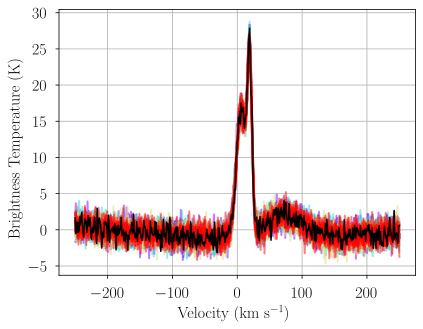

In [17]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive.{ext}"
)
SVG(f"{figdir}/posterior_predictive.{ext}")

In [18]:
model.plot_traces(f"{figdir}/traces.{ext}")
SVG(f"{figdir}/traces.{ext}")

A much better solution! We can inspect the posterior distribution pair plots. First, the cloud parameters.

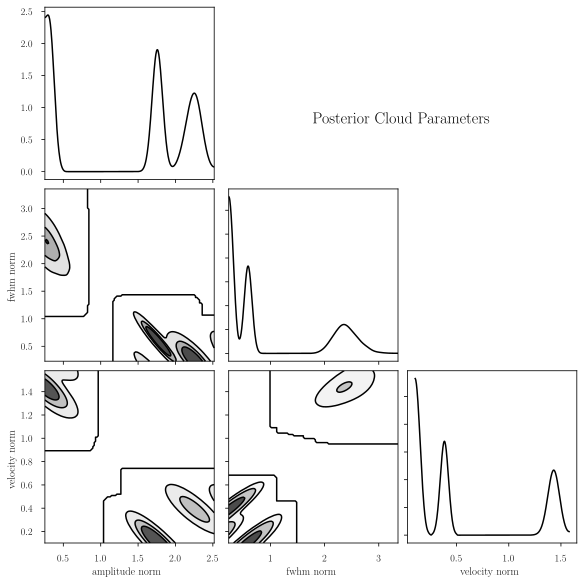

In [19]:
plot_pair(
    model.trace.solution_0, # samples
    model.cloud_params, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params.{ext}")

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions for a single cloud.

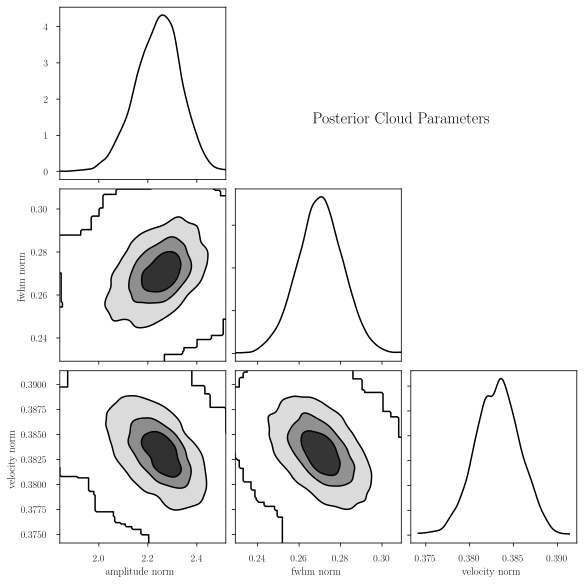

In [20]:
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    model.cloud_params, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_0.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params_0.{ext}")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [21]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 1506.0426655497104


mean      sd  hdi_16%  hdi_84%
amplitude[0]   22.403   0.924   21.451   23.248
amplitude[1]   17.575   0.378   17.178   17.926
amplitude[2]    3.200   0.193    2.989    3.370
fwhm[0]         8.105   0.331    7.806    8.455
fwhm[1]        17.537   0.880   16.653   18.397
fwhm[2]        71.795   6.563   63.519   76.400
velocity[0]    19.158   0.127   19.031   19.281
velocity[1]     6.232   0.387    5.836    6.596
velocity[2]    71.463   2.088   69.837   73.910
line_area[0]  193.426  13.281  182.098  207.916
line_area[1]  328.001  16.129  311.369  342.941
line_area[2]  244.087  21.805  220.363  263.223